# 02 - APD Data Explorer

**Purpose:** Exploratory data analysis and visualization for burglary-focused
campus risk modeling.

**Input:**
- `../data/processed/apd/target_crimes.csv`

**Output:**
- Figures saved to `../reports/figures/`
- Statistical summaries
- Feature insights for modeling

**Analyses:**
1. Temporal patterns (hourly, daily, seasonal)
2. Spatial patterns (NPU risk maps, campus hotspots)
3. Weather correlations
4. Offense category breakdowns
5. Campus proximity analysis

**Team:** Run this for data insights before modeling.
**Runtime:** ~2–3 minutes depending on environment.

In [1]:
# === Imports =================================================================
from pathlib import Path
from typing import List, Dict, Any

import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import contextily as ctx
from shapely.geometry import Point

from rich.console import Console
from rich.table import Table
from rich.panel import Panel
from rich import print as rprint

from sklearn.neighbors import KernelDensity

# Initialize console
console = Console()

console.print(
    Panel.fit(
        "Libraries imported successfully for EDA.\n\n"
        "Ready to explore:\n"
        "- Temporal patterns\n"
        "- Spatial hotspots\n"
        "- Weather correlations\n"
        "- Campus proximity analysis",
        title="02 Explorer - Imports Complete",
        border_style="cyan",
    )
)

╭───── 02 Explorer - Imports Complete ─────╮
│ Libraries imported successfully for EDA. │
│                                          │
│ Ready to explore:                        │
│ - Temporal patterns                      │
│ - Spatial hotspots                       │
│ - Weather correlations                   │
│ - Campus proximity analysis              │
╰──────────────────────────────────────────╯

In [2]:
# === Configuration ===========================================================
DATA_DIR = Path("../data")
PROCESSED_DATA_FOLDER = DATA_DIR / "processed" / "apd"
SHAPEFILES_DIR = DATA_DIR / "raw" / "shapefiles"
FIGURES_DIR = Path("../reports/figures")

# Create figures directory
FIGURES_DIR.mkdir(parents=True, exist_ok=True)

# Shapefiles
NPU_SHP = SHAPEFILES_DIR / "atl_npu_sf" / "atl_npu_boundaries.shp"
CITIES_SHP = SHAPEFILES_DIR / "census_boundary_2024_sf" / "ga_census_places_2024.shp"

# School centers (for GSU buffer visualization; same as wrangler constants)
SCHOOL_CENTERS = {
    "GSU": (33.7530, -84.3863),
    "GA_Tech": (33.7756, -84.3963),
    "Emory": (33.7925, -84.3239),
    "Clark": (33.7533, -84.4124),
    "Spelman": (33.7460, -84.4129),
    "Morehouse": (33.7483, -84.4126),
    "Morehouse_Med": (33.7505, -84.4131),
    "Atlanta_Metro": (33.7145, -84.4020),
    "Atlanta_Tech": (33.7126, -84.4034),
    "SCAD": (33.7997, -84.3920),
    "John_Marshall": (33.7621, -84.3896),
}

console.print(
    Panel.fit(
        "[bold cyan]Paths configured.[/bold cyan]\n\n"
        f"Data: [yellow]{PROCESSED_DATA_FOLDER}[/yellow]\n"
        f"Figures: [yellow]{FIGURES_DIR}[/yellow]\n"
        f"Shapefiles: [yellow]{SHAPEFILES_DIR}[/yellow]",
        title="Configuration",
        border_style="cyan",
    )
)

╭────────── Configuration ───────────╮
│ Paths configured.                  │
│                                    │
│ Data: ../data/processed/apd        │
│ Figures: ../reports/figures        │
│ Shapefiles: ../data/raw/shapefiles │
╰────────────────────────────────────╯

In [3]:
# === Pipeline Logging (reuse pattern from 01_wrangler) =======================
pipeline_log: List[Dict[str, Any]] = []


def log_step(step_name: str, df: pd.DataFrame) -> None:
    """Record a pipeline step with shape info."""
    if not isinstance(df, pd.DataFrame) or df.empty:
        rows_val = "N/A"
        cols_val = "N/A"
        rows_str = rows_val
        cols_str = cols_val
    else:
        rows_val = int(df.shape[0])
        cols_val = int(df.shape[1])
        rows_str = f"{rows_val:,}"
        cols_str = str(cols_val)

    pipeline_log.append({"step": step_name, "rows": rows_val, "cols": cols_val})
    console.print(f"[green]✓ {step_name}[/green] [cyan]→ shape: {rows_str} x {cols_str}[/cyan]")


def show_pipeline_table() -> None:
    """Display a Rich table summarizing all steps."""
    if not pipeline_log:
        console.print("[red]No steps logged yet.[/red]")
        return

    table = Table(title="📊 Explorer Pipeline Summary", show_lines=True)
    table.add_column("Step", style="cyan", no_wrap=True)
    table.add_column("Rows", style="green")
    table.add_column("Cols", style="yellow")

    for entry in pipeline_log:
        rows_val = entry["rows"]
        cols_val = entry["cols"]
        rows_str = f"{rows_val:,}" if isinstance(rows_val, int) else str(rows_val)
        cols_str = str(cols_val) if isinstance(cols_val, int) else str(cols_val)
        table.add_row(entry["step"], rows_str, cols_str)

    console.print(table)


console.print(Panel("[bold green]Logger configured.[/bold green]", border_style="green"))

╭─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╮
│ Logger configured.                                                                                              │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

In [4]:
# === Load Processed Data =====================================================
console.print(Panel("[bold cyan]Loading processed crime data...[/bold cyan]", border_style="cyan"))

INPUT_PATH = PROCESSED_DATA_FOLDER / "target_crimes.csv"

if not INPUT_PATH.exists():
    console.print(f"[bold red]ERROR:[/bold red] File not found: {INPUT_PATH}")
    console.print("[yellow]Please run 01_wrangler.ipynb first![/yellow]")
    raise FileNotFoundError(f"Required file missing: {INPUT_PATH}")

df = pd.read_csv(INPUT_PATH)
df["report_date"] = pd.to_datetime(df["report_date"])

log_step("Step 0: Loaded processed data", df)

console.print(
    Panel.fit(
        f"[bold green]✓ Data loaded successfully![/bold green]\n\n"
        f"Records: [cyan]{len(df):,}[/cyan]\n"
        f"Columns: [cyan]{len(df.columns)}[/cyan]\n"
        f"Date range: [cyan]{df['report_date'].min().date()} "
        f"to {df['report_date'].max().date()}[/cyan]",
        title="Data Summary",
        border_style="green",
    )
)

# Optional peek (comment out if you don't want the big table)
df.head()

╭─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╮
│ Loading processed crime data...                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

/tmp/ipykernel_321697/2844953297.py:11: DtypeWarning: Columns (16) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(INPUT_PATH)


✓ Step 0: Loaded processed data → shape: 117,749 x 70

╭──────────── Data Summary ────────────╮
│ ✓ Data loaded successfully!          │
│                                      │
│ Records: 117,749                     │
│ Columns: 70                          │
│ Date range: 2021-01-01 to 2025-11-27 │
╰──────────────────────────────────────╯

,objectid,incident_number,report_date,day_of_the_week,day_number,crime_against,nibrs_ucr_code,nibrs_offense,street_address,location_type,...,near_ga_tech,near_emory,near_clark,near_spelman,near_morehouse,near_morehouse_med,near_atlanta_metro,near_atlanta_tech,near_scad,near_john_marshall
0,13460100,213470772,2021-12-13 18:50:38,Sunday,1,Property,23H,all other larceny,2325 cheshire bridge rd ne,grocery_supermarket,...,0,0,0,0,0,0,0,0,0,0
1,13460101,213470731,2021-12-13 18:20:59,Monday,1,Property,23F,theft from motor vehicle,471 n highland ave ne,parking_drop_lot_garage,...,0,0,0,0,0,0,0,0,0,0
2,13460102,213470690,2021-12-16 12:41:52,Monday,4,Property,23F,theft from motor vehicle,3699 lenox rd ne,residence_home,...,0,0,0,0,0,0,0,0,0,0
3,13460104,213470602,2021-12-13 16:44:48,Monday,1,Property,23H,all other larceny,1043 harwell st nw,highway_road_alley_street_sidewalk,...,0,0,1,0,0,0,0,0,0,0
4,13460105,213470405,2021-12-13 13:23:50,Saturday,1,Property,23F,theft from motor vehicle,2637 old hapeville rd sw,residence_home,...,0,0,0,0,0,0,0,0,0,0


╭─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╮
│ STEP 1: Core temporal EDA                                                                                       │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

  💾 Saved: 01_crimes_by_hour.png

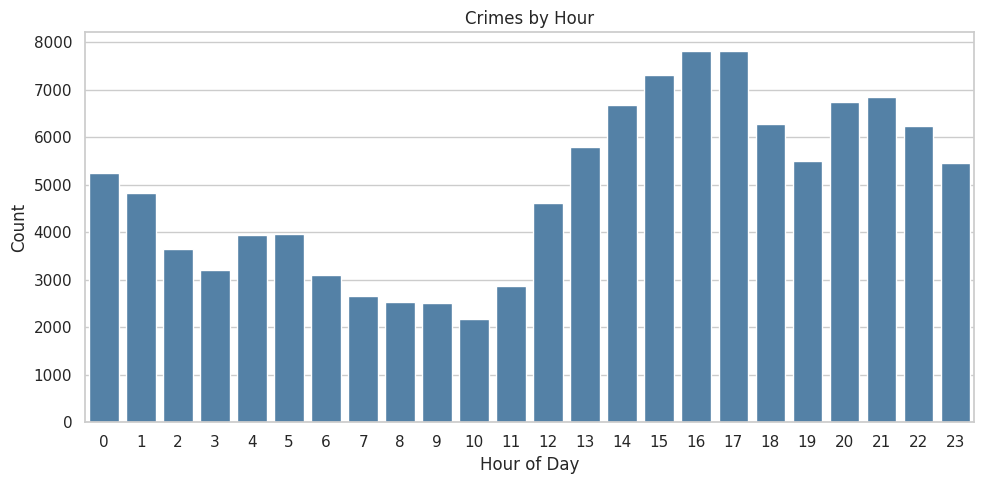

  💾 Saved: 02_crimes_by_day_of_week.png

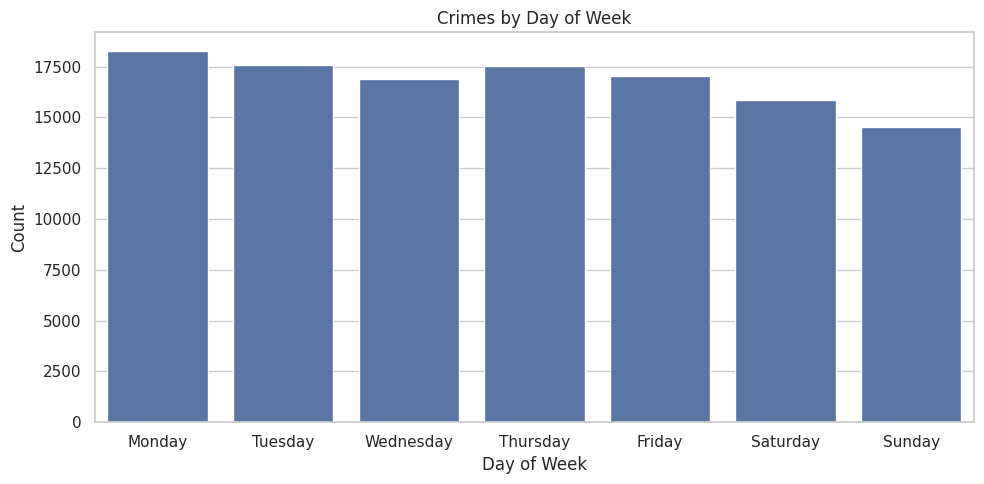

  💾 Saved: 03_heatmap_day_hour.png

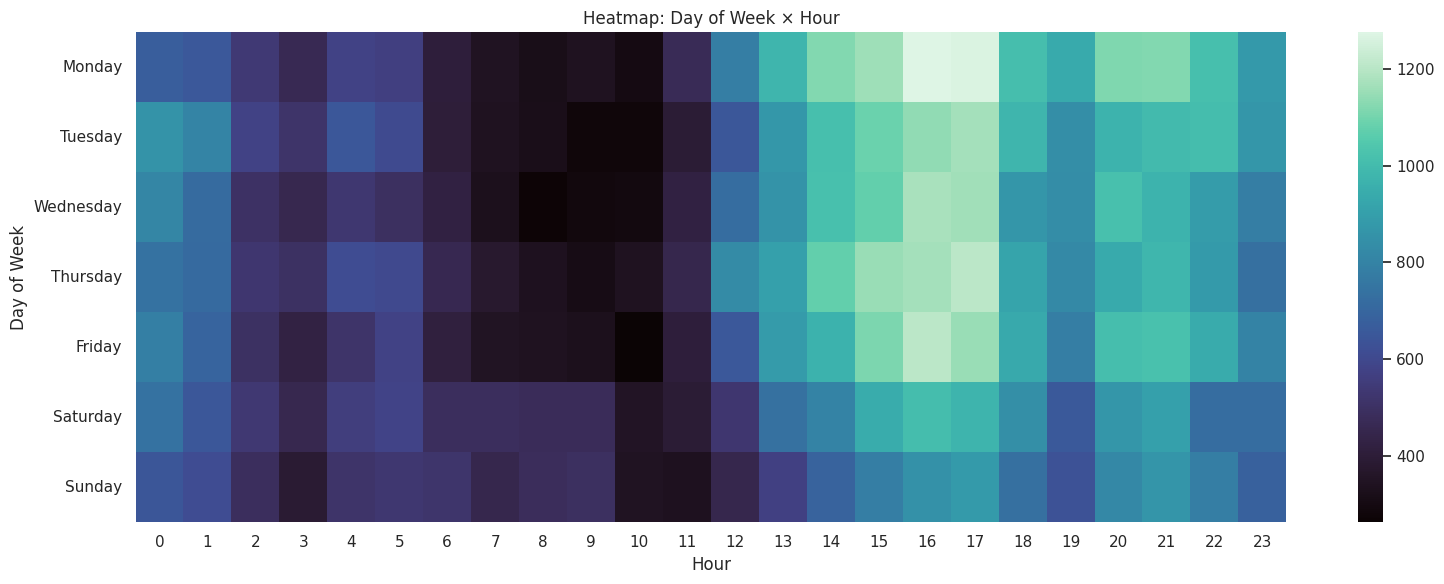

  💾 Saved: 04_temperature_distribution.png

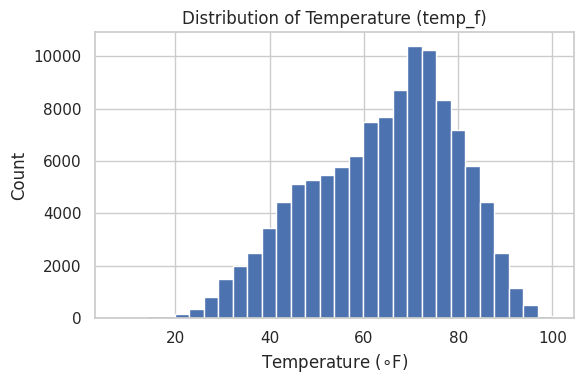

✓ Step 1: Core temporal visualizations (hour/day/month) → shape: 117,749 x 70

In [5]:
console.print(Panel("[bold magenta]STEP 1: Core temporal EDA[/bold magenta]", border_style="magenta"))

eda_df = df.copy()
date_range_str = f"{eda_df['year'].min()}–{eda_df['year'].max()}"

# Build GeoDataFrame once for spatial EDA later
gdf_full = gpd.GeoDataFrame(
    eda_df.dropna(subset=["longitude", "latitude"]),
    geometry=gpd.points_from_xy(eda_df.longitude, eda_df.latitude),
    crs="EPSG:4326",
)

sns.set(style="whitegrid")

# --- 1.1 Crimes by hour ------------------------------------------------------
plt.figure(figsize=(10, 5))
sns.countplot(x="incident_hour", data=eda_df, color="steelblue")
plt.title("Crimes by Hour")
plt.xlabel("Hour of Day")
plt.ylabel("Count")
plt.tight_layout()
fig_path = FIGURES_DIR / "01_crimes_by_hour.png"
plt.savefig(fig_path, dpi=300, bbox_inches="tight")
console.print(f"[dim cyan]  💾 Saved: {fig_path.name}[/dim cyan]")
plt.show()

# --- 1.2 Crimes by day of week ----------------------------------------------
if "day_of_week" in eda_df.columns:
    order = [
        "Monday",
        "Tuesday",
        "Wednesday",
        "Thursday",
        "Friday",
        "Saturday",
        "Sunday",
    ]
    plt.figure(figsize=(10, 5))
    sns.countplot(x="day_of_week", data=eda_df, order=order)
    plt.title("Crimes by Day of Week")
    plt.xlabel("Day of Week")
    plt.ylabel("Count")
    plt.tight_layout()
    fig_path = FIGURES_DIR / "02_crimes_by_day_of_week.png"
    plt.savefig(fig_path, dpi=300, bbox_inches="tight")
    console.print(f"[dim cyan]  💾 Saved: {fig_path.name}[/dim cyan]")
    plt.show()

# --- 1.3 Heatmap day_of_week × hour -----------------------------------------
pivot = (
    eda_df.pivot_table(
        index="day_of_week",
        columns="incident_hour",
        values="incident_number",
        aggfunc="count",
    )
    .fillna(0)
)

pivot = pivot.reindex(
    ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
)

plt.figure(figsize=(16, 6))
sns.heatmap(pivot, cmap="mako")
plt.title("Heatmap: Day of Week × Hour")
plt.xlabel("Hour")
plt.ylabel("Day of Week")
plt.tight_layout()
fig_path = FIGURES_DIR / "03_heatmap_day_hour.png"
plt.savefig(fig_path, dpi=300, bbox_inches="tight")
console.print(f"[dim cyan]  💾 Saved: {fig_path.name}[/dim cyan]")
plt.show()

# --- 1.4 Temperature distribution -------------------------------------------
if "temp_f" in eda_df.columns:
    plt.figure(figsize=(6, 4))
    eda_df["temp_f"].hist(bins=30)
    plt.title("Distribution of Temperature (temp_f)")
    plt.xlabel(r"Temperature ($\circ$F)")
    plt.ylabel("Count")
    plt.tight_layout()
    fig_path = FIGURES_DIR / "04_temperature_distribution.png"
    plt.savefig(fig_path, dpi=300, bbox_inches="tight")
    console.print(f"[dim cyan]  💾 Saved: {fig_path.name}[/dim cyan]")
    plt.show()

# --- 1.5 Interactive monthly comparison (Plotly) ----------------------------
monthly_data = (
    eda_df.groupby([eda_df["year"], eda_df["month"]])
    .size()
    .reset_index(name="count")
)
monthly_data["year"] = monthly_data["year"].astype(str)
month_names = ["Jan", "Feb", "Mar", "Apr", "May", "Jun",
               "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]

fig = px.line(
    monthly_data,
    x="month",
    y="count",
    color="year",
    title="Monthly Crime Trends by Year (Interactive)",
    labels={"month": "Month", "count": "Number of Crimes", "year": "Year"},
    markers=True,
)

fig.update_xaxes(
    tickmode="linear",
    tick0=1,
    dtick=1,
    ticktext=month_names,
    tickvals=list(range(1, 13)),
)
fig.update_layout(hovermode="x unified", height=600)
fig.show()

log_step("Step 1: Core temporal visualizations (hour/day/month)", eda_df)

In [6]:
console.print(
    Panel(
        "[bold cyan]STEP 2: Advanced temporal binning (6 × 4-hour bins)[/bold cyan]",
        border_style="cyan",
    )
)

# Overall time-bin distribution using 6 custom blocks
time_bin_order = [
    "Early Night (0–4)",
    "Early Morning (5–8)",
    "Late Morning (9–12)",
    "Afternoon (13–16)",
    "Evening (17–20)",
    "Late Night (21–24)",
]

time_bin_counts = (
    eda_df["hour_block"]
    .value_counts()
    .reindex(time_bin_order)
)

colors_bins = ["#2C3E50", "#34495E", "#95A5A6", "#E67E22", "#E74C3C", "#8E44AD"]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# 2.1 Overall time-block distribution
ax1.bar(
    range(len(time_bin_counts)),
    time_bin_counts.values,
    color=colors_bins,
    edgecolor="black",
)
ax1.set_xticks(range(len(time_bin_counts)))
ax1.set_xticklabels(
    [label.split(" ")[0] for label in time_bin_counts.index],
    rotation=45,
    ha="right",
)
ax1.set_title("Crime Distribution by Time Block (All Years)")
ax1.set_ylabel("Number of Crimes")
ax1.set_xlabel("Time Block")
ax1.grid(axis="y", alpha=0.3)

for i, v in enumerate(time_bin_counts.values):
    ax1.text(
        i,
        v + max(time_bin_counts.values) * 0.01,
        f"{v:,}",
        ha="center",
        fontweight="bold",
    )

# 2.2 Time-block by year
time_bin_year = (
    eda_df.groupby(["year", "hour_block"])
    .size()
    .unstack(fill_value=0)
    .reindex(columns=time_bin_order)
)

x = np.arange(len(time_bin_year.index))
width = 0.14

for i, (bin_name, color) in enumerate(zip(time_bin_year.columns, colors_bins)):
    ax2.bar(
        x + i * width,
        time_bin_year[bin_name].values,
        width,
        label=bin_name.split(" ")[0],
        color=color,
        edgecolor="black",
    )

ax2.set_title("Crime by Time Block and Year")
ax2.set_xlabel("Year")
ax2.set_ylabel("Number of Crimes")
ax2.set_xticks(x + width * 2.5)
ax2.set_xticklabels(time_bin_year.index)
ax2.legend(title="Time Block", loc="upper right", fontsize=9, ncol=2)
ax2.grid(axis="y", alpha=0.3)

plt.tight_layout()
fig_path = FIGURES_DIR / "05_time_block_distribution.png"
plt.savefig(fig_path, dpi=300, bbox_inches="tight")
console.print(f"[dim cyan]  💾 Saved: {fig_path.name}[/dim cyan]")
plt.show()

# 2.3 Crimes per year
crimes_per_year = eda_df["year"].value_counts().sort_index()

fig, ax = plt.subplots(figsize=(12, 6))
crimes_per_year.plot(kind="bar", color="steelblue", ax=ax, edgecolor="black")
ax.set_title(f"Total Crimes Per Year ({date_range_str})")
ax.set_xlabel("Year")
ax.set_ylabel("Number of Crimes")
ax.grid(axis="y", alpha=0.3)

for i, v in enumerate(crimes_per_year.values):
    ax.text(
        i,
        v + max(crimes_per_year.values) * 0.01,
        f"{v:,}",
        ha="center",
        fontweight="bold",
    )

plt.xticks(rotation=0)
plt.tight_layout()
fig_path = FIGURES_DIR / "06_crimes_by_year.png"
plt.savefig(fig_path, dpi=300, bbox_inches="tight")
console.print(f"[dim cyan]  💾 Saved: {fig_path.name}[/dim cyan]")
plt.show()

# 2.4 Crimes by day of week (bar)
day_order = [
    "Monday",
    "Tuesday",
    "Wednesday",
    "Thursday",
    "Friday",
    "Saturday",
    "Sunday",
]
day_crimes = eda_df["day_of_week"].value_counts().reindex(day_order)

fig, ax = plt.subplots(figsize=(12, 6))
ax.bar(
    range(len(day_crimes)),
    day_crimes.values,
    color="lightblue",
    edgecolor="black",
)
ax.set_title("Crimes by Day of Week")
ax.set_xlabel("Day of Week")
ax.set_ylabel("Number of Crimes")
ax.set_xticks(range(len(day_order)))
ax.set_xticklabels(day_order, rotation=45, ha="right")
ax.grid(axis="y", alpha=0.3)

for i, v in enumerate(day_crimes.values):
    ax.text(
        i,
        v + max(day_crimes.values) * 0.01,
        f"{v:,}",
        ha="center",
        fontweight="bold",
    )

plt.tight_layout()
fig_path = FIGURES_DIR / "07_crimes_by_day_bar.png"
plt.savefig(fig_path, dpi=300, bbox_inches="tight")
console.print(f"[dim cyan]  💾 Saved: {fig_path.name}[/dim cyan]")
plt.show()

log_step("Step 2: Advanced temporal EDA (6-bin blocks & yearly trends)", eda_df)

╭─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╮
│ STEP 2: Advanced temporal binning (6 × 4-hour bins)                                                             │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

KeyError: 'hour_block'

In [ ]:
console.print(
    Panel(
        "[bold cyan]STEP 3: Spatial EDA – NPU choropleth, KDE, hexbin, GSU buffers[/bold cyan]",
        border_style="cyan",
    )
)

# Build GeoDataFrames for spatial EDA
gdf_3857 = gdf_full.to_crs(epsg=3857)
gdf_npu = gpd.read_file(NPU_SHP).to_crs(3857)
gdf_cities = gpd.read_file(CITIES_SHP).to_crs(3857)
atlanta_boundary = gdf_cities[gdf_cities["NAME"] == "Atlanta"].iloc[0].geometry

# Identify the shapefile column with NPU name/label
candidate_npu_cols = ["NPU", "NPU_ID", "NPU_NUM", "NPU_NAME", "NAME"]
npu_col_shp = next((c for c in candidate_npu_cols if c in gdf_npu.columns), gdf_npu.columns[0])
npu_col = "npu"

# 3.1 NPU choropleth with labels
npu_counts = eda_df.groupby(npu_col).size().reset_index(name="crime_count")
gdf_npu_plot = gdf_npu.merge(
    npu_counts, left_on=npu_col_shp, right_on=npu_col, how="left"
).fillna(0)

fig, ax = plt.subplots(figsize=(16, 16))
gdf_npu_plot.plot(
    column="crime_count",
    cmap="Reds",
    legend=True,
    edgecolor="black",
    linewidth=1.5,
    ax=ax,
    legend_kwds={"label": "Total crimes", "shrink": 0.7},
)

for idx, row in gdf_npu_plot.iterrows():
    centroid = row.geometry.centroid
    label = row[npu_col_shp]
    count = int(row["crime_count"])
    ax.text(
        centroid.x,
        centroid.y,
        f"{label}\n({count:,})",
        fontsize=9,
        ha="center",
        fontweight="bold",
        bbox=dict(boxstyle="round", facecolor="white", alpha=0.7),
    )

ax.set_title(f"Crime density by NPU ({date_range_str})")
ax.axis("off")
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron)
plt.tight_layout()
fig_path = FIGURES_DIR / "08_npu_choropleth.png"
plt.savefig(fig_path, dpi=300, bbox_inches="tight")
console.print(f"[dim cyan]  💾 Saved: {fig_path.name}[/dim cyan]")
plt.show()

# 3.2 KDE hotspot map
coords = np.vstack([gdf_3857.geometry.x, gdf_3857.geometry.y]).T
kde = KernelDensity(bandwidth=400, kernel="gaussian").fit(coords)

atl_bounds = atlanta_boundary.bounds
x_margin = (atl_bounds[2] - atl_bounds[0]) * 0.1
y_margin = (atl_bounds[3] - atl_bounds[1]) * 0.1

xmin = atl_bounds[0] - x_margin
xmax = atl_bounds[2] + x_margin
ymin = atl_bounds[1] - y_margin
ymax = atl_bounds[3] + y_margin

xx, yy = np.mgrid[xmin:xmax:300j, ymin:ymax:300j]
grid_points = np.vstack([xx.ravel(), yy.ravel()]).T
z = np.exp(kde.score_samples(grid_points)).reshape(xx.shape)

fig, ax = plt.subplots(figsize=(16, 16))
im = ax.imshow(
    z.T,
    extent=[xmin, xmax, ymin, ymax],
    origin="lower",
    cmap="hot",
    alpha=0.8,
    vmin=z.max() * 0.3,
)

gdf_npu.boundary.plot(ax=ax, edgecolor="black", linewidth=1.5, alpha=0.7)
gpd.GeoSeries([atlanta_boundary]).boundary.plot(ax=ax, edgecolor="black", linewidth=2)

plt.colorbar(im, ax=ax, label="Crime density", shrink=0.7)
ax.set_title("Kernel density crime hotspot map")
ax.axis("off")
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron)
plt.tight_layout()
fig_path = FIGURES_DIR / "09_kde_hotspot_map.png"
plt.savefig(fig_path, dpi=300, bbox_inches="tight")
console.print(f"[dim cyan]  💾 Saved: {fig_path.name}[/dim cyan]")
plt.show()

# 3.3 Hexbin with NPU overlay
fig, ax = plt.subplots(figsize=(16, 16))
hb = ax.hexbin(
    gdf_3857.geometry.x,
    gdf_3857.geometry.y,
    gridsize=70,
    cmap="Purples",
    mincnt=1,
    extent=[xmin, xmax, ymin, ymax],
    vmin=1,
)

gdf_npu.boundary.plot(ax=ax, edgecolor="black", linewidth=1.5, alpha=0.7)
gpd.GeoSeries([atlanta_boundary]).boundary.plot(ax=ax, edgecolor="black", linewidth=2)

plt.colorbar(hb, ax=ax, label="Crime count per hexagon", shrink=0.7)
ax.set_title("Hexbin spatial density with NPU overlay")
ax.axis("off")
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron)
plt.tight_layout()
fig_path = FIGURES_DIR / "10_hexbin_density.png"
plt.savefig(fig_path, dpi=300, bbox_inches="tight")
console.print(f"[dim cyan]  💾 Saved: {fig_path.name}[/dim cyan]")
plt.show()

# 3.4 GSU campus buffers
gsu_pt = Point(SCHOOL_CENTERS["GSU"][1], SCHOOL_CENTERS["GSU"][0])
gsu_3857 = gpd.GeoSeries([gsu_pt], crs=4326).to_crs(3857).iloc[0]

buffers = {
    "0.25 mile": gsu_3857.buffer(402.336),
    "0.5 mile": gsu_3857.buffer(804.672),
    "1 mile": gsu_3857.buffer(1609.34),
}

max_buffer = buffers["1 mile"]
bounds = gpd.GeoSeries([max_buffer]).total_bounds
buffer_margin = 800

fig, ax = plt.subplots(figsize=(16, 16))

buffer_styles = [
    ("0.25 mile", "red", 2.5),
    ("0.5 mile", "orange", 2),
    ("1 mile", "yellow", 1.5),
]

for name, color, lw in buffer_styles:
    gpd.GeoSeries([buffers[name]]).plot(
        ax=ax,
        alpha=0,
        edgecolor=color,
        linewidth=lw,
        label=f"{name} radius",
        facecolor="none",
        linestyle="-",
    )

crimes_in_area = gdf_3857.cx[bounds[0] : bounds[2], bounds[1] : bounds[3]]
crimes_in_area.plot(
    ax=ax,
    color="red",
    markersize=2,
    alpha=0.4,
    label=f"Crime incidents (n={len(crimes_in_area):,})",
)

gpd.GeoSeries([gsu_3857]).plot(
    ax=ax,
    color="blue",
    markersize=60,
    marker="*",
    zorder=5,
    label="GSU campus center",
    edgecolor="white",
    linewidth=1,
)

ax.set_xlim(bounds[0] - buffer_margin, bounds[2] + buffer_margin)
ax.set_ylim(bounds[1] - buffer_margin, bounds[3] + buffer_margin)

ax.set_title("Crimes within GSU campus buffers\nGSU center: (33.7530 N, 84.3863 W)")
ax.legend(loc="upper left", fontsize=10, framealpha=0.95)
ax.axis("off")
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron)
plt.tight_layout()
fig_path = FIGURES_DIR / "11_gsu_campus_buffers.png"
plt.savefig(fig_path, dpi=300, bbox_inches="tight")
console.print(f"[dim cyan]  💾 Saved: {fig_path.name}[/dim cyan]")
plt.show()

log_step("Step 3: Spatial EDA (NPU choropleth, KDE, hexbin, GSU buffers)", eda_df)

In [ ]:
console.print(
    Panel(
        "[bold cyan]STEP 4: Comprehensive crime statistics summary[/bold cyan]",
        border_style="cyan",
    )
)

# Offense breakdown
if "offense_category" in eda_df.columns:
    console.print("[cyan]Offense Category Breakdown[/cyan]")
    console.print(eda_df["offense_category"].value_counts().to_string())

summary_table = Table(
    title=f"COMPREHENSIVE CRIME STATISTICS SUMMARY ({date_range_str})",
    show_header=False,
    show_lines=True,
)
summary_table.add_column("Metric", style="cyan")
summary_table.add_column("Value", style="green")

summary_table.add_row("[bold]Total Crimes[/bold]", f"{len(eda_df):,}")
summary_table.add_row(
    "[bold]Date Range[/bold]",
    f"{eda_df['report_date'].min().date()} → {eda_df['report_date'].max().date()}",
)

# Temporal insights
temporal_table = Table(
    title="Temporal Insights",
    show_header=True,
    header_style="bold yellow",
    show_lines=True,
)
temporal_table.add_column("Time Metric", style="cyan")
temporal_table.add_column("Peak Value", style="green")
temporal_table.add_column("Count", justify="right", style="magenta")

temporal_table.add_row(
    "Peak Hour",
    f"{eda_df['incident_hour'].mode()[0]:02}:00",
    f"{eda_df['incident_hour'].value_counts().max():,}",
)
temporal_table.add_row(
    "Peak Day",
    f"{eda_df['day_of_week'].mode()[0]}",
    f"{eda_df['day_of_week'].value_counts().max():,}",
)
month_names_map = {
    i: name
    for i, name in enumerate(
        ["Jan", "Feb", "Mar", "Apr", "May", "Jun",
         "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"],
        1,
    )
}
temporal_table.add_row(
    "Peak Month",
    f"{month_names_map[eda_df['month'].mode()[0]]}",
    f"{eda_df['month'].value_counts().max():,}",
)
temporal_table.add_row(
    "Peak Year",
    f"{eda_df['year'].mode()[0]}",
    f"{eda_df['year'].value_counts().max():,}",
)

# Time block analysis
time_block_table = Table(
    title="Time Block Analysis (6 × 4-Hour Bins)",
    show_header=True,
    header_style="bold yellow",
    show_lines=True,
)
time_block_table.add_column("Time Block", style="cyan")
time_block_table.add_column("Count", justify="right", style="green")
time_block_table.add_column("Percent", justify="right", style="magenta")

for block_name in time_bin_order:
    if "hour_block" in eda_df.columns:
        count = (eda_df["hour_block"] == block_name).sum()
        pct = (count / len(eda_df)) * 100
        time_block_table.add_row(block_name, f"{count:,}", f"{pct:.1f}%")

# Day-of-week table
day_of_week_table = Table(
    title="Day of Week Analysis",
    show_header=True,
    header_style="bold yellow",
    show_lines=True,
)
day_of_week_table.add_column("Day", style="cyan")
day_of_week_table.add_column("Count", justify="right", style="green")
day_of_week_table.add_column("Percent", justify="right", style="magenta")

for day in day_order:
    count = (eda_df["day_of_week"] == day).sum()
    pct = (count / len(eda_df)) * 100
    day_of_week_table.add_row(day, f"{count:,}", f"{pct:.1f}%")

rprint(summary_table)
rprint(temporal_table)
rprint(time_block_table)
rprint(day_of_week_table)

log_step("Step 4: Comprehensive crime statistics summary (Rich)", eda_df)

In [ ]:
console.print(Panel("[bold cyan]STEP 5: Weather correlation analysis[/bold cyan]", border_style="cyan"))

if {"is_hot", "is_cold", "is_raining"}.issubset(df.columns):
    weather_table = Table(title="Crime Rates by Weather Condition", show_header=True)
    weather_table.add_column("Condition", style="cyan")
    weather_table.add_column("Crime Count", justify="right", style="green")
    weather_table.add_column("% of Total", justify="right", style="yellow")

    conditions = [
        ("Hot Days (85th percentile+)", df["is_hot"] == 1),
        ("Cold Days (15th percentile-)", df["is_cold"] == 1),
        ("Rainy Days", df["is_raining"] == 1),
        (
            "Normal Weather",
            (df["is_hot"] == 0) & (df["is_cold"] == 0) & (df["is_raining"] == 0),
        ),
    ]

    for name, mask in conditions:
        count = mask.sum()
        pct = (count / len(df)) * 100
        weather_table.add_row(name, f"{count:,}", f"{pct:.1f}%")

    console.print(weather_table)

log_step("Step 5: Weather correlation analysis", df)

In [ ]:
console.print(Panel("[bold cyan]STEP 6: Campus proximity analysis[/bold cyan]", border_style="cyan"))

if "campus_label" in df.columns:
    campus_crimes = (
        df[df["campus_label"] != "none"]
        .groupby("campus_label")
        .size()
        .sort_values(ascending=False)
    )

    campus_table = Table(title="Top 5 Campuses by Crime Count", show_header=True)
    campus_table.add_column("Campus", style="cyan")
    campus_table.add_column("Crimes (within 1.5mi)", justify="right", style="green")

    for campus, count in campus_crimes.head(5).items():
        campus_table.add_row(campus, f"{count:,}")

    console.print(campus_table)

log_step("Step 6: Campus proximity analysis", df)

In [ ]:
console.print("\n[bold magenta]═══ Exploration Complete ═══[/bold magenta]\n")

summary_stats = {
    "Total Crimes Analyzed": f"{len(df):,}",
    "Date Range": f"{df['report_date'].min().date()} to {df['report_date'].max().date()}",
    "NPUs Covered": f"{df['npu'].nunique()}",
    "Peak Crime Hour": f"{df['incident_hour'].mode()[0]:02}:00",
    "Peak Crime Day": df["day_of_week"].mode()[0],
    "Figures Generated": len(list(FIGURES_DIR.glob("*.png"))),
}

final_table = Table(show_header=False, show_lines=True)
final_table.add_column("Metric", style="cyan")
final_table.add_column("Value", style="green")

for metric, value in summary_stats.items():
    final_table.add_row(metric, str(value))

console.print(final_table)
console.print(f"\n[bold cyan]📁 All figures saved to:[/bold cyan] {FIGURES_DIR}")
console.print("[bold green]✓ 02_explorer.ipynb complete![/bold green]")
console.print("[yellow]Next: Run 03_model.ipynb for predictive modeling on NPU × hour panels.[/yellow]")

show_pipeline_table()

## ✅ Next Steps

Use insights from this notebook to:

- Finalize **feature selection** for the NPU × hour models
- Sanity-check seasonality, peak times, and campus risk zones
- Feed into `03_model.ipynb`:
  - Temporal: `hour_block`, `day_of_week`, `is_weekend`, `month`, `year`
  - Spatial: `npu`, `zone_int`, `campus_distance_m`
  - Weather: `temp_f`, `is_raining`, `is_hot`, `is_cold`
  - Context: `is_holiday`, `is_daylight`